# Time to get your hands dirty! The transient Universe

## Task 
Let's go back to our previous example on the astrophysical transient.
8. Fit the same model from before with the same priors, but this time use nested sampling.
$$
y = b, \quad \text{for } t < t_0
$$

$$
y = b + A \exp[-\alpha (t - t_0)], \quad \text{for } t \geq t_0
$$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used ppf from scipy.stats.uniform, but there are other ways to do it)
An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

9. Another possible model that may explain the data is a Gaussian profile described by:
$$
y = b + A \exp[-(t - t_0)^2/2\sigma_g^2], \quad \text{for } t \geq t_0
$$
Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

10. Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data? Express this in terms of the Jeffrey's scale.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import corner
import dynesty
from dynesty import plotting as dyplot

In [2]:
data=np.load("transient.npy")
time=data[:,0]# first column: time
flux = data[:, 1]  # second column: flux
error = data[:, 2]  # third column: uncertainties

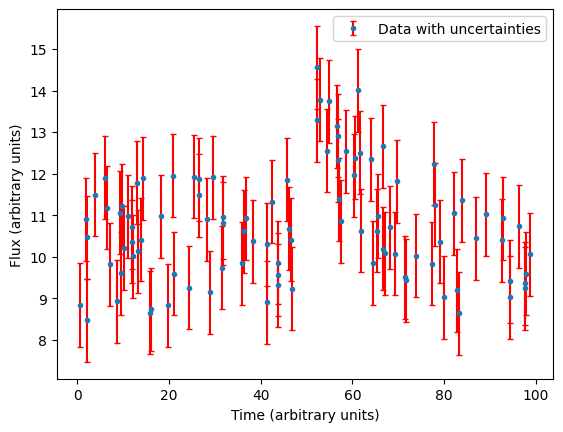

In [3]:
plt.errorbar(time,flux, yerr=error,fmt='.', label='Data with uncertainties', ecolor='red', capsize=2)
plt.xlabel('Time (arbitrary units)')
plt.ylabel('Flux (arbitrary units)')
plt.legend()
plt.show()

In [4]:
def model(parameters):
    b, A, ln_alpha, t0 = parameters 
    t=time 
    y = np.zeros_like(t)
    for i in range(len(t)):
        if t[i] < t0:
            y[i] = b
        else:
            y[i] = b + A * np.exp(-np.exp(ln_alpha) * (t[i] - t0))
    return y

def loglikelihood(parameters):
    y_model = model(parameters)
    y_obs=flux
    sigma=error
    return -0.5 * np.sum(((y_obs - y_model) / sigma)**2 + np.log(2 * np.pi * sigma**2))

In [ ]:
def prior(u):
    b = 50*u[0]  
    A = 50*u[1]    
    ln_alpha= 5*(2*u[2]-1)  
    t0 = 100*u[3]
    return [b,A,ln_alpha,t0]


In [ ]:
ndim = 4 # Number of parameters in the model
sampler = dynesty.NestedSampler(loglikelihood, prior, ndim)
sampler.run_nested() # Run the nested sampling algorithm
sresults = sampler.results

4206it [00:50, 17.19it/s, bound: 121 | nc: 17 | ncall: 109003 | eff(%):  3.859 | loglstar:   -inf < -175.166 <    inf | logz: -184.655 +/-  0.116 | dlogz: 32.966 >  0.509]  /home/sara/myenv/lib/python3.10/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
4217it [00:52, 11.60it/s, bound: 125 | nc: 26 | ncall: 112044 | eff(%):  3.764 | loglstar:   -inf < -174.890 <    inf | logz: -184.583 +/-  0.117 | dlogz: 32.873 >  0.509]/home/sara/myenv/lib/python3.10/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you a

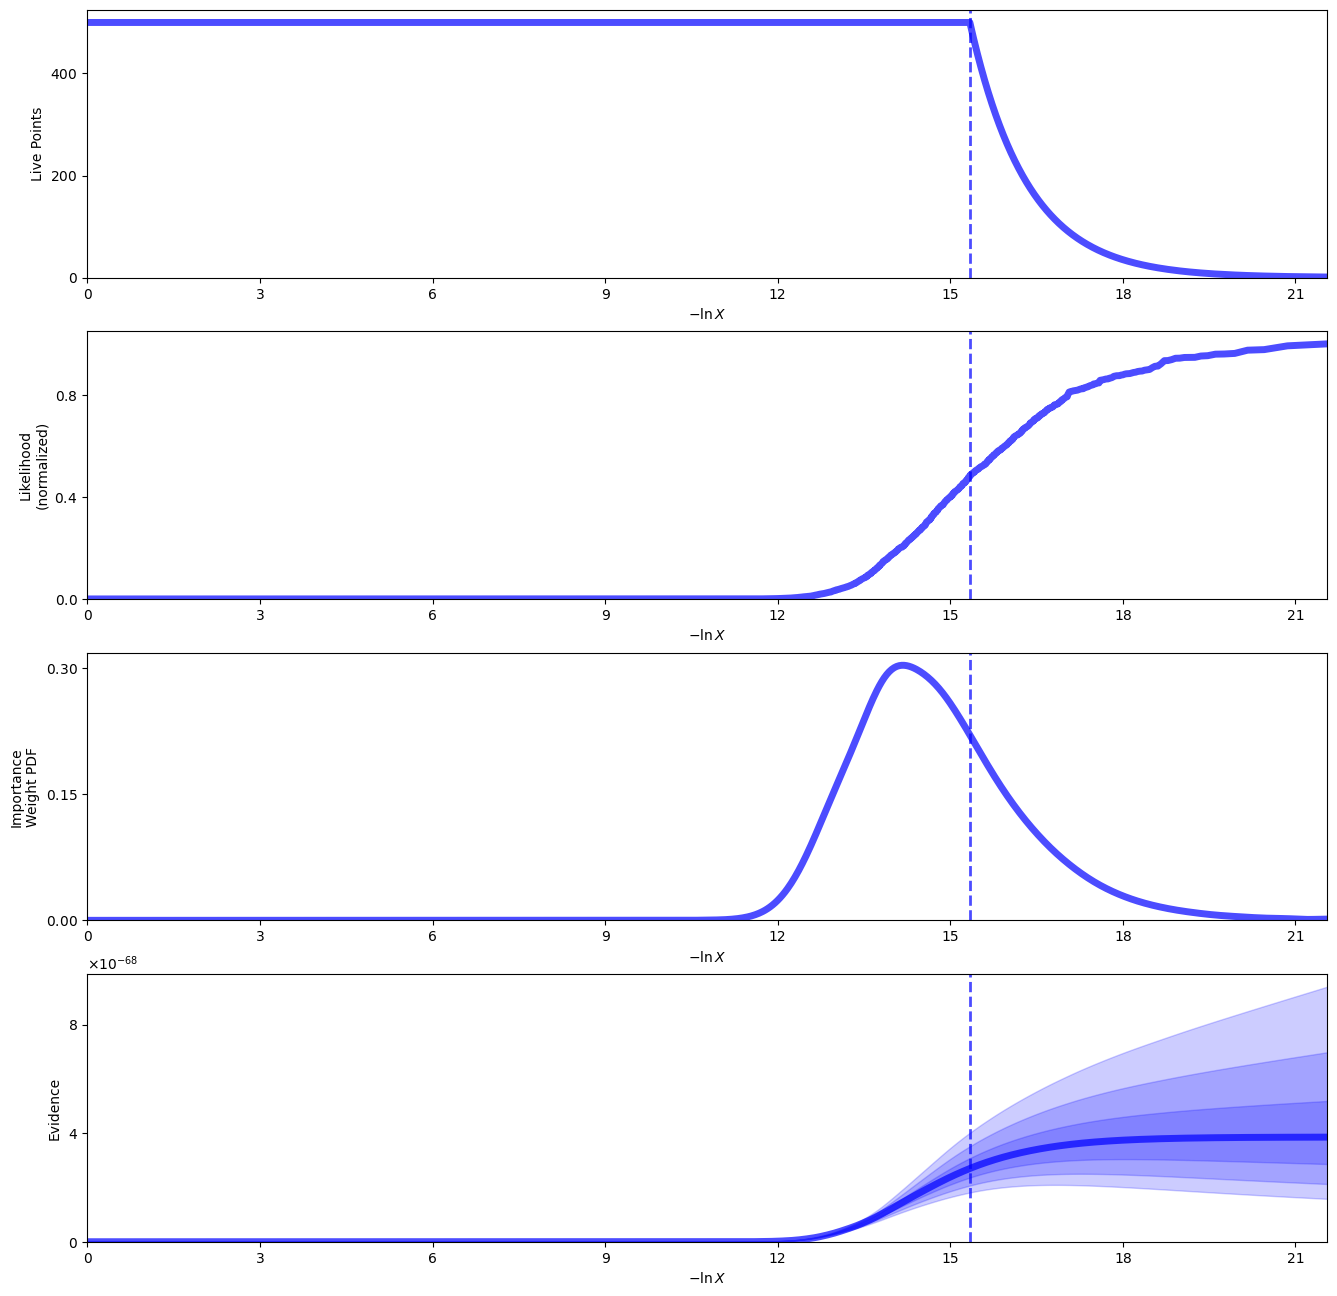

In [7]:
rfig, raxes = dyplot.runplot(sresults)

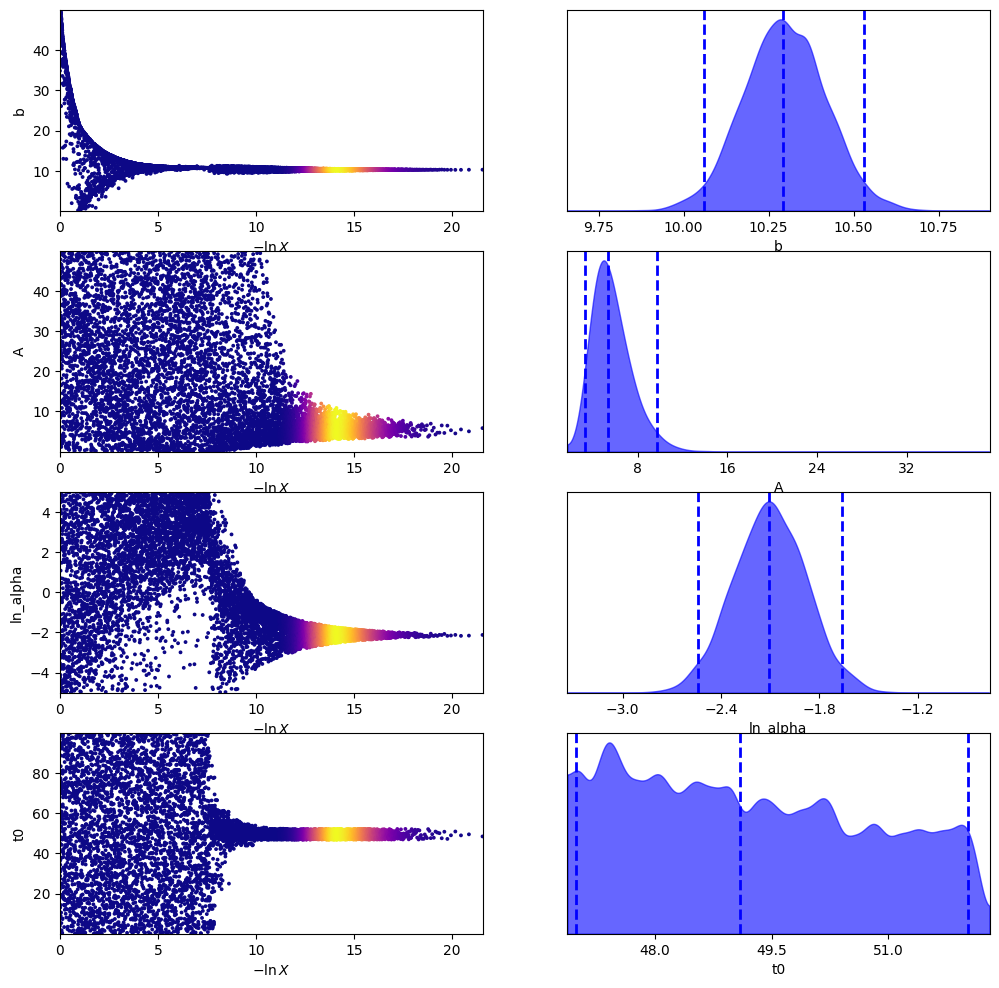

In [8]:
labels = ["b","A", "ln_alpha", "t0"]
tfig, taxes = dyplot.traceplot(sresults, labels=labels)

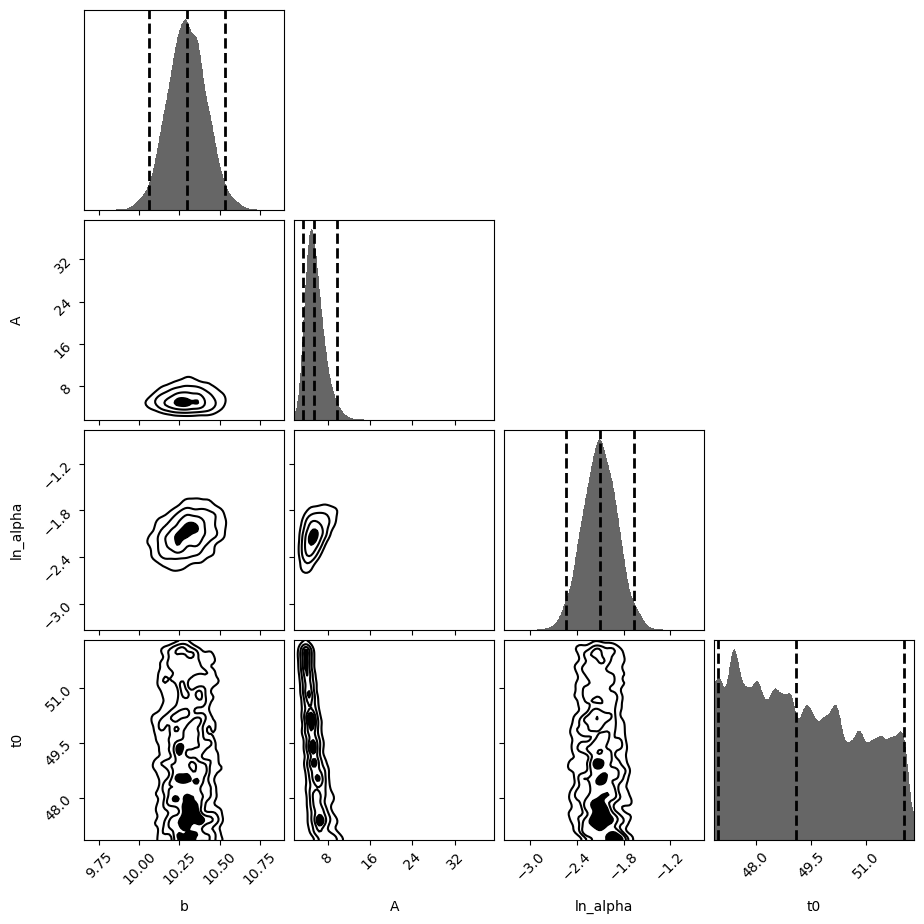

In [9]:
cfig, caxes = dyplot.cornerplot(sresults, labels=labels)

In [20]:
def modelgauss(parameters):
    b, A, ln_sigma_g, t0 = parameters
    sigma_g = np.exp(ln_sigma_g)
    y = b + A * np.exp(-((time - t0)**2) / (2 * sigma_g**2))
    return y

def loglikelihoodgauss(parameters):
    y_model = modelgauss(parameters)
    y_obs=flux
    sigma=error
    return -0.5 * np.sum(((y_obs - y_model) / sigma)**2 + np.log(2 * np.pi * sigma**2))

def priorgauss(u):
    b = 50 * u[0]                         
    A = 50 * u[1]                        
    ln_sigma_g = 5*(2*u[2] - 1)          
    t0 = 100 * u[3]                        
    return [b, A, ln_sigma_g, t0]
 


In [21]:
ndim = 4

samplergauss = dynesty.NestedSampler(loglikelihoodgauss,priorgauss, ndim)
samplergauss.run_nested()
sresultsgauss = samplergauss.results

3917it [00:23, 18.19it/s, bound: 54 | nc: 18 | ncall: 58398 | eff(%):  6.707 | loglstar:   -inf < -178.587 <    inf | logz: -185.283 +/-  0.108 | dlogz: 29.949 >  0.509]    /home/sara/myenv/lib/python3.10/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
3920it [00:23, 15.24it/s, bound: 55 | nc: 168 | ncall: 58645 | eff(%):  6.684 | loglstar:   -inf < -178.557 <    inf | logz: -185.281 +/-  0.108 | dlogz: 29.941 >  0.509]/home/sara/myenv/lib/python3.10/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you ar

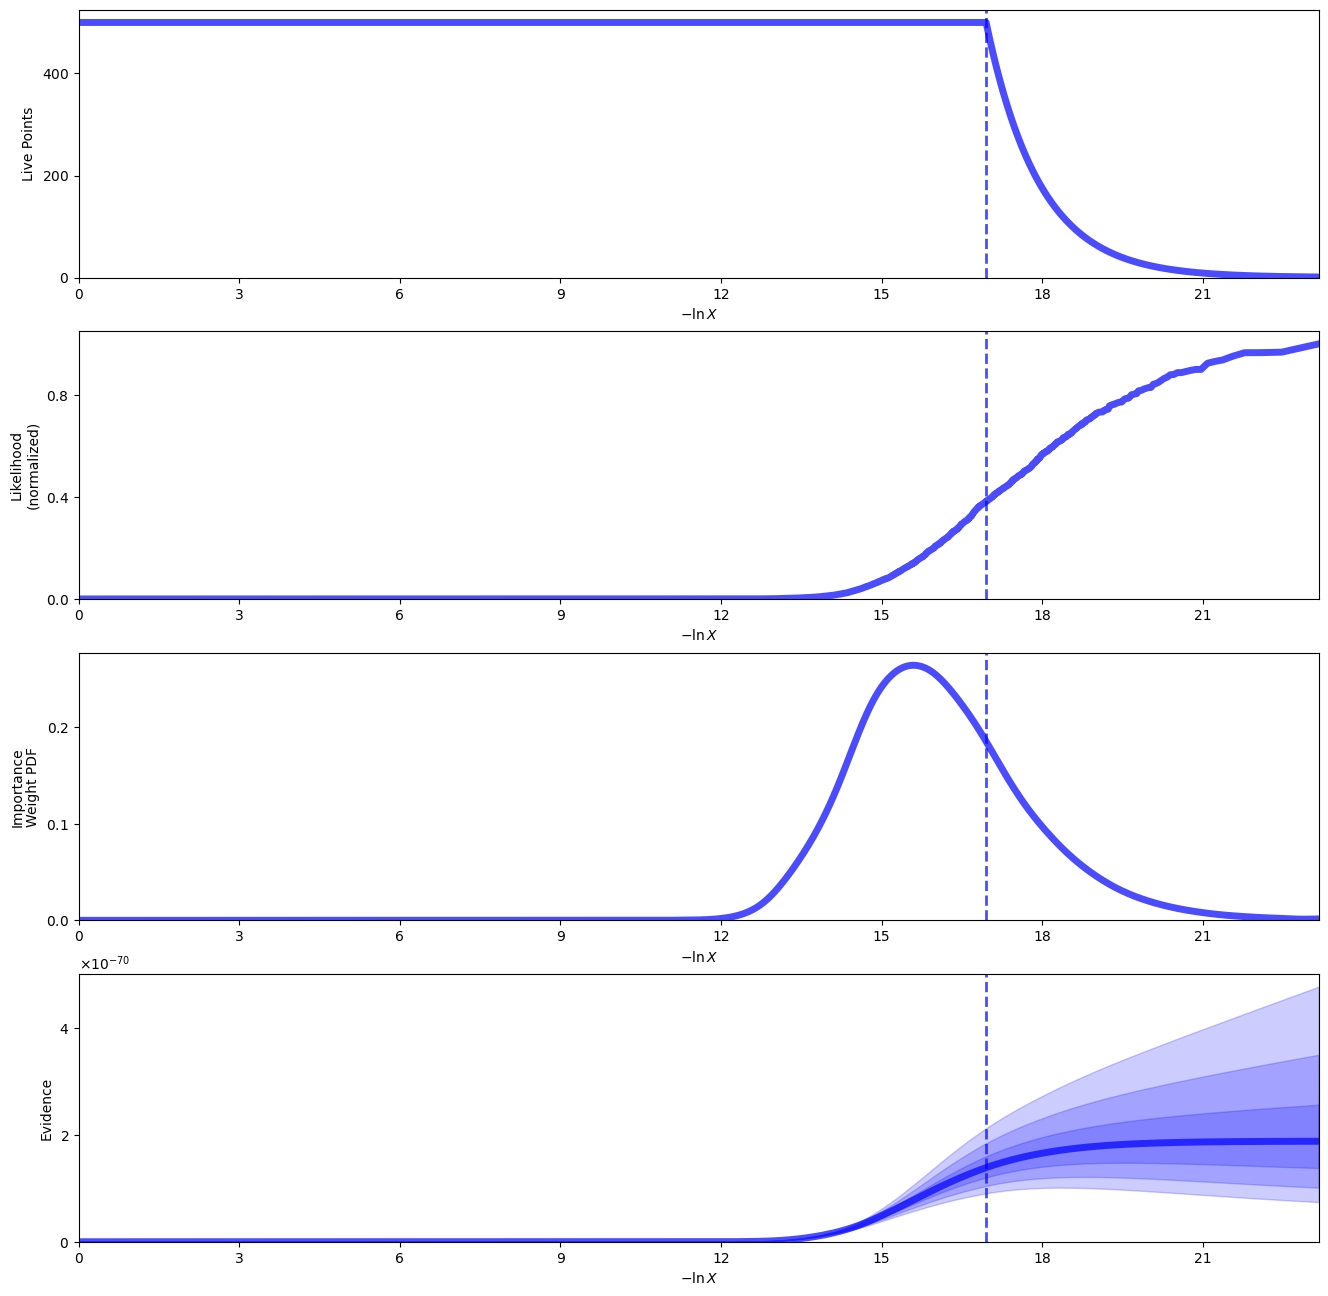

In [22]:
rfig, raxes = dyplot.runplot(sresultsgauss)

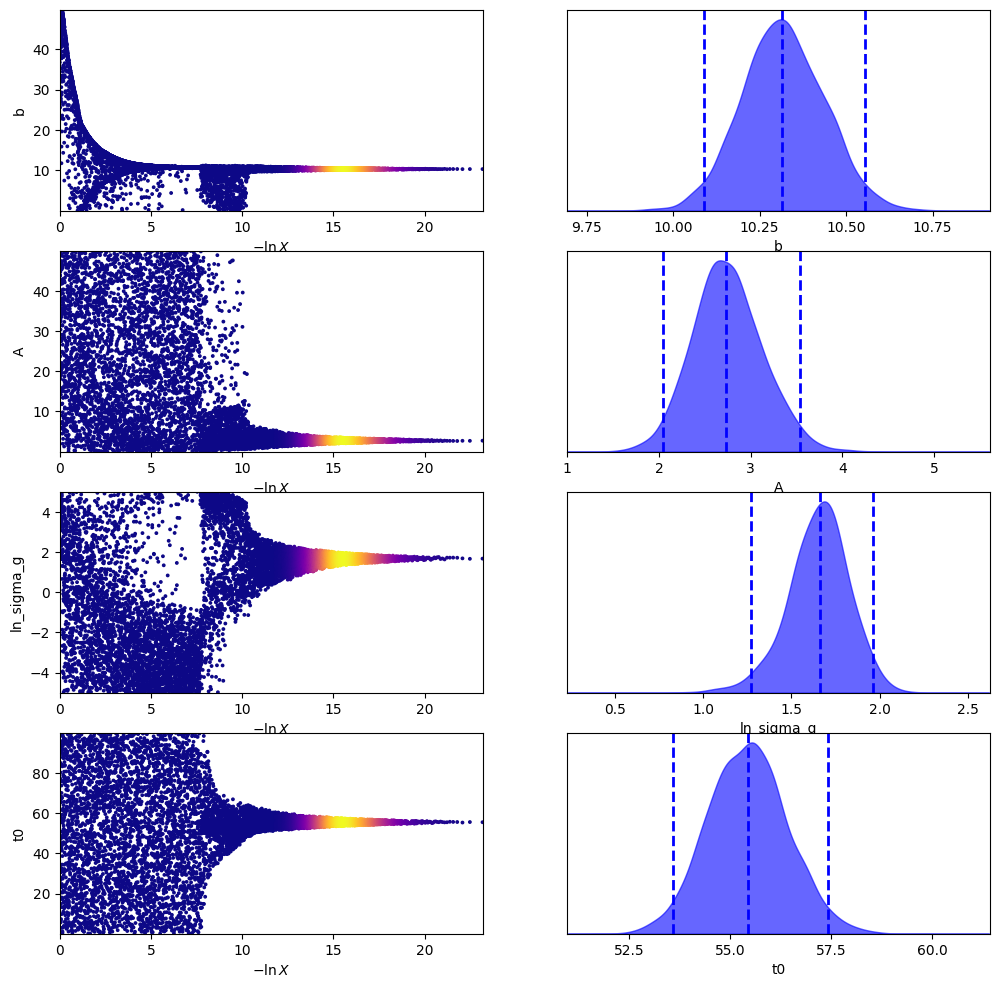

In [23]:
labels = ["b","A", "ln_sigma_g", "t0"]
tfig, taxes = dyplot.traceplot(sresultsgauss, labels=labels)

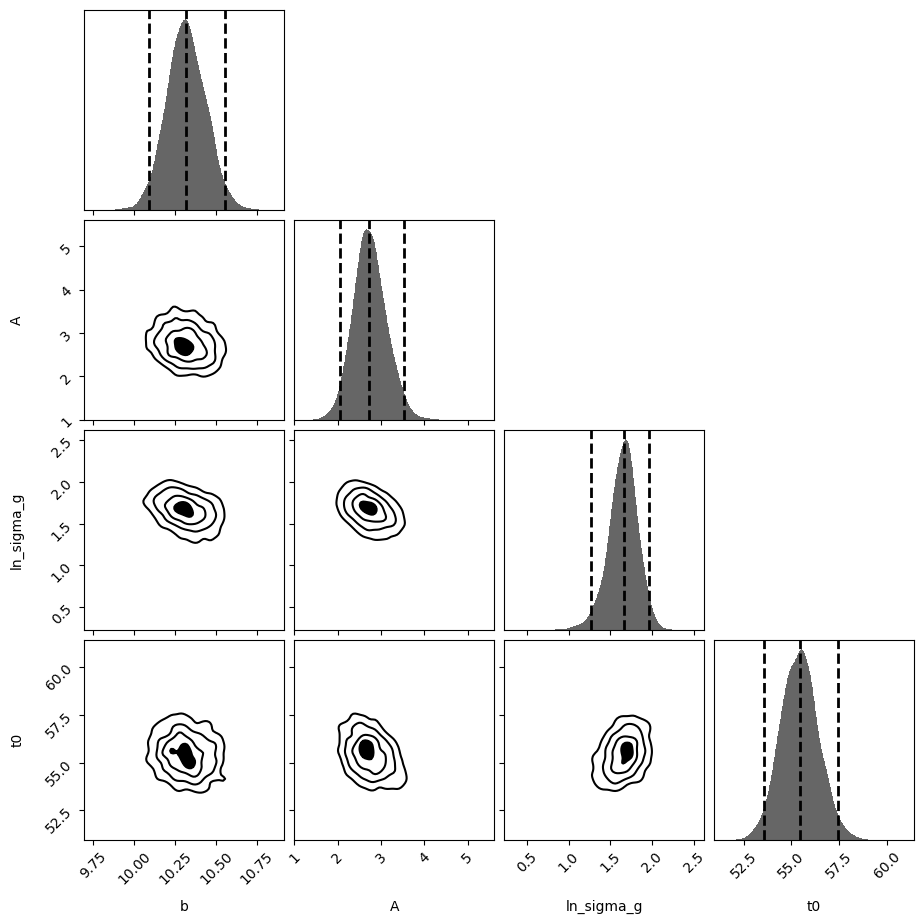

In [24]:
cfig, caxes = dyplot.cornerplot(sresultsgauss, labels=labels)

In [31]:
Bburst = np.exp(sresults.logz[-1])
Bgauss = np.exp(sresultsgauss.logz[-1])
BF = Bgauss/Bburst
lnBF = sresultsgauss.logz[-1] - sresults.logz[-1]

# Interpretazione secondo Jeffreys scale
if lnBF < 0:
    interpretazione = "Negative (supports burst model)"
elif lnBF < 1.1:
    interpretazione = "Barely worth mentioning"
elif lnBF < 2.3:
    interpretazione = "Substantial evidence for Gaussian"
elif lnBF < 3.4:
    interpretazione = "Strong evidence for Gaussian"
elif lnBF < 4.6:
    interpretazione = "Very strong evidence for Gaussian"
else:
    interpretazione = "Decisive evidence for Gaussian"

print(f"Bayes Factor (Gauss vs Burst): {BF}")
print(f"Interpretazione secondo Jeffreys: {interpretazione}")


Bayes Factor (Gauss vs Burst): 0.004885450943679627
Interpretazione secondo Jeffreys: Negative (supports burst model)
